In [99]:
import pymongo
from pprint import pprint
from datetime import datetime
import seaborn as sns
import pandas as pd
from typing import List, Set, Tuple
import functools as ft
import spacy
nlp = spacy.load("en_core_web_sm")

In [2]:
def utc_to_dt(utc: float) -> datetime:
    """Convert a unix time to a python datetime."""
    return datetime.utcfromtimestamp(int(utc))

In [3]:
# define mongo connection
conn = pymongo.MongoClient('localhost', 27017)
db = conn["drug_pricing"]
coll = db["praw"]

In [51]:
# generate a dataframe of random samples
n_samples = 100000
query = coll.aggregate([{ "$sample": {"size": n_samples} }])
samp_df = pd.DataFrame(list(query))

In [52]:
# format dataframe
samp_df["dt"] = samp_df.time.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
samp_df["year"] = samp_df.dt.apply(lambda x: str(x.year))

## Average Number of Comments Per Post Over Time

Text(0.5, 1.0, 'Average Number of Comments Per Post Over Time')

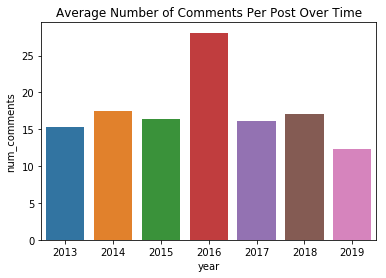

In [54]:
comm_df = samp_df.loc[:,["year", "num_comments"]].dropna().groupby("year").mean().reset_index()
ax = sns.barplot(x=comm_df.year, y=comm_df.num_comments)
ax.set_title("Average Number of Comments Per Post Over Time")

## Active Number of Users on R/Opiates Over Time

In [76]:
def users_per_year(df: pd.DataFrame) -> Tuple[List[str], List[int]]:
    """
    Find the number of unique users per year in the given df.
    
    Note: assumes columns names "username" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    user_counts: List[int] = [df.loc[df.year == year, "author"].unique().shape[0] for year in years]
    return years, user_counts

Text(0.5, 1.0, 'Number of r/opiates Active Users Over Time')

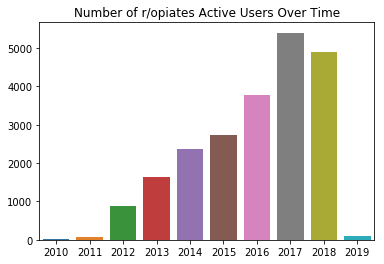

In [78]:
years, user_counts = users_per_year(samp_df)
ax = sns.barplot(x=years, y=user_counts)
ax.set_title("Number of r/opiates Active Users Over Time")

## Number of Posts Over Time

Text(0.5, 1.0, 'Number of r/opiates Posts Over Time')

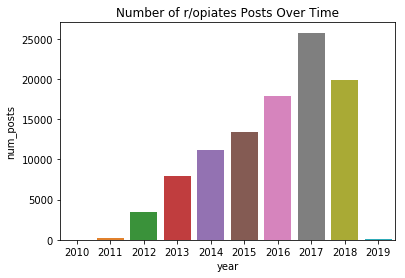

In [105]:
count_df = samp_df.groupby("year").count().reset_index().loc[:, ["year", "_id"]]
count_df.columns = ["year", "num_posts"]
norm_posts: List[float] = [p / u for p, u in zip(count_df["num_posts"], user_counts)]
ax = sns.barplot(x=count_df.year, y=count_df["num_posts"])
ax.set_title("Number of r/opiates Posts Over Time")

## Word Usage Over Time

In [88]:
def word_per_year(df: pd.DataFrame, word: str) -> Tuple[List[str], List[int]]:
    """
    Find the number of occurrences of the word per year in the df.
    
    Note: assumes columns names "text" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    check_in = lambda text: 1 if word in str(text).split() else 0
    countw = lambda year: df.loc[df.year == year, "text"].apply(check_in).sum()
    word_counts: List[int] = [countw(year) for year in years]
    return years, word_counts

Text(0.5, 1.0, "Frequency of 'fentanyl' Use per Year")

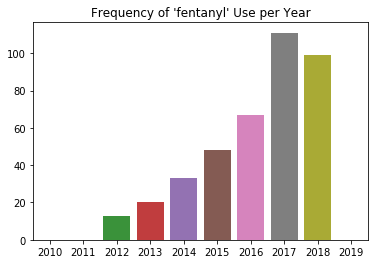

In [113]:
word = "fentanyl"
years, word_counts = word_per_year(samp_df, word)
norm_wc: List[float] = [w / u for w, u in zip(word_counts, user_counts)]
ax = sns.barplot(x=years, y=word_counts)
ax.set_title(f"Frequency of '{word}' Use per Year")

## Spacy Location Extraction

In [98]:
docs = [nlp(t) for t in samp_df.text[0:100]]

In [100]:
ents = ft.reduce(lambda acc, d: acc + list(d.ents), docs, [])

In [108]:
[e.label_ for e in ents]

['DATE',
 'DATE',
 'CARDINAL',
 'DATE',
 'ORG',
 'DATE',
 'MONEY',
 'DATE',
 'CARDINAL',
 'DATE',
 'TIME',
 'DATE',
 'PERSON',
 'CARDINAL',
 'ORG',
 'ORG',
 'DATE',
 'ORG',
 'DATE',
 'ORG',
 'PERSON',
 'DATE',
 'GPE',
 'PERSON',
 'ORG',
 'ORG',
 'TIME',
 'CARDINAL',
 'PERSON',
 'ORG',
 'ORG',
 'CARDINAL',
 'CARDINAL',
 'DATE',
 'GPE',
 'DATE',
 'CARDINAL',
 'CARDINAL',
 'CARDINAL',
 'CARDINAL',
 'CARDINAL',
 'CARDINAL',
 'PERSON',
 'DATE',
 'ORDINAL',
 'ORG',
 'CARDINAL',
 'CARDINAL',
 'PERSON',
 'CARDINAL',
 'ORG',
 'PERSON',
 'DATE',
 'ORG',
 'GPE',
 'MONEY',
 'ORG',
 'PERSON',
 'GPE',
 'ORG',
 'MONEY',
 'CARDINAL',
 'ORG',
 'ORG',
 'CARDINAL',
 'MONEY',
 'ORDINAL',
 'CARDINAL',
 'ORG',
 'GPE',
 'ORG',
 'ORG',
 'TIME',
 'TIME',
 'DATE',
 'DATE',
 'PERSON',
 'PERSON',
 'CARDINAL',
 'PERCENT',
 'TIME',
 'TIME',
 'ORG',
 'PERCENT',
 'GPE',
 'ORG',
 'ORG',
 'GPE',
 'CARDINAL',
 'CARDINAL',
 'QUANTITY',
 'ORDINAL',
 'DATE',
 'ORDINAL',
 'CARDINAL',
 'CARDINAL',
 'PERSON',
 'DATE',
 'ORDIN

In [104]:
for e in ents:
    if e.label_ == "GPE":
        print(e.text)

Washington
Colorado
Georgia
Bitcoin
Opioids
Methadone
Methadone
Valium


In [ ]:
# sample process of grouping
query_str = {
    "$group": {
        "_id": {
            "year": { "$year": "$date" }
        },
        "count": { "$sum": 1 }
    }
}
query = coll.aggregate(query_str)
df = pd.DataFrame(list(query))
df.columns = ["year", "count"]
sns.barplot(x=df.year, y=df.count)